In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [3]:
def pred_target(df):
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df = df[df.price < 400]
    
    df = df.reset_index(drop=True)
    X = df[[x for x in df.columns if x not in ['price','bhk']]]
    y = df.price.values
    target = np.log(y)
    formula = "target ~ "+' + '.join(X)+' -1'
    y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
    y = y.values.ravel()
    return X, y
    

In [4]:
berlin = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Berlin_dfm.csv',
                   encoding='utf8')

In [5]:
berlin.shape

(14796, 15)

In [45]:
df_corr = berlin[[x for x in berlin.columns if x not in ['Unnamed: 0','bhk']]].corr()

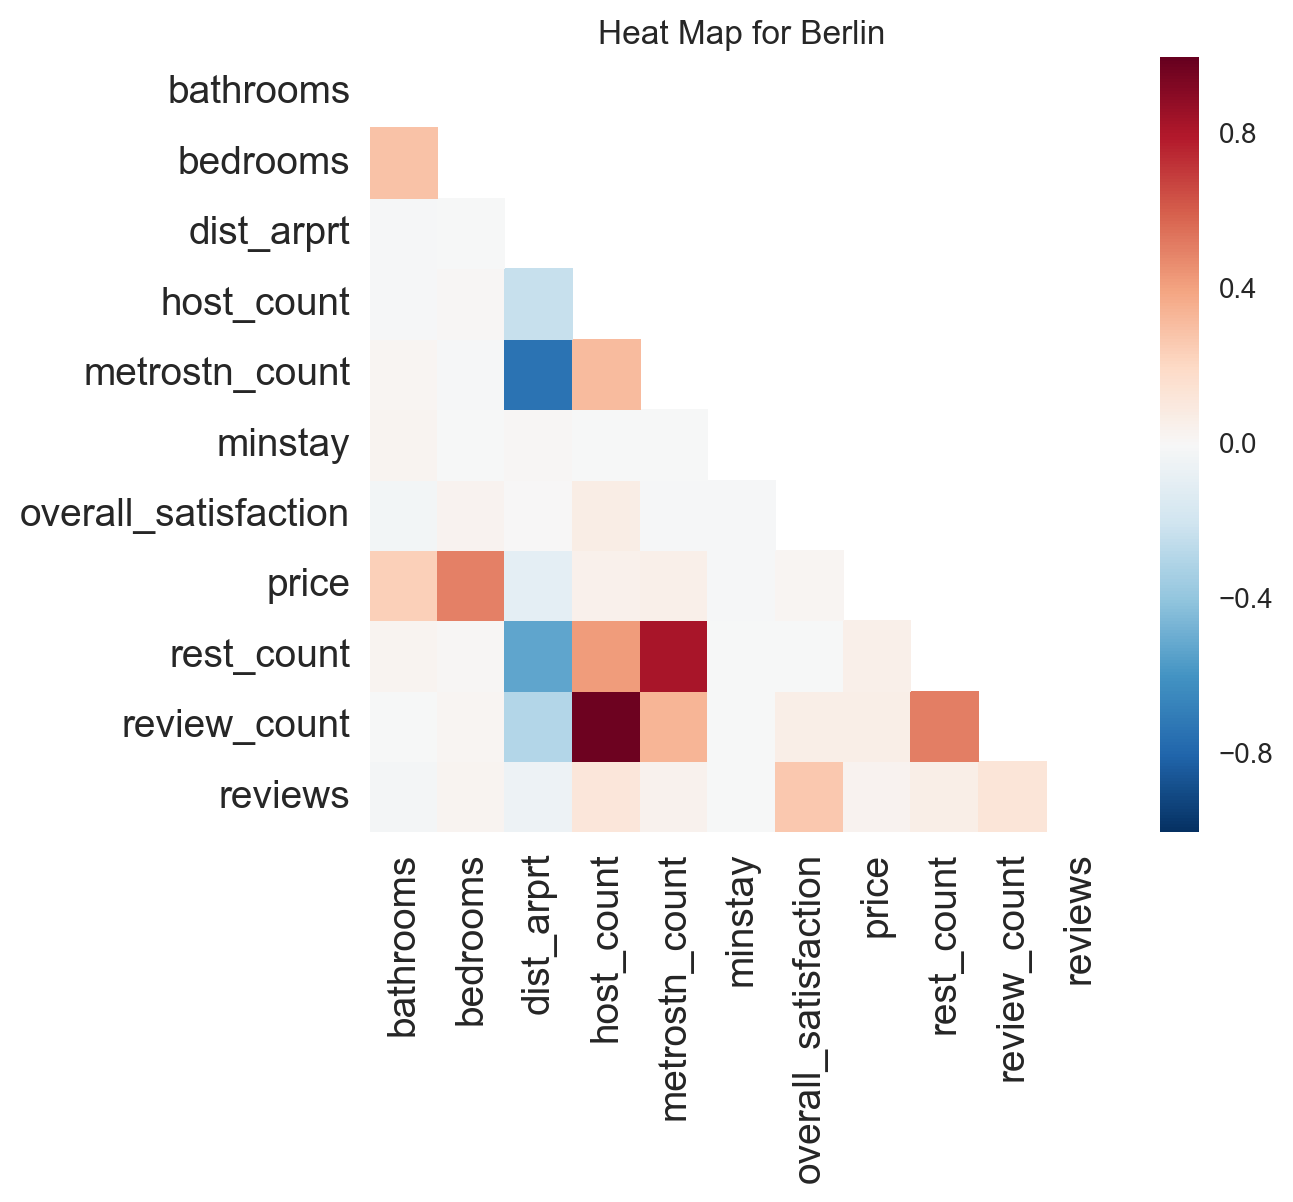

In [46]:
#for heatmap Set the default matplotlib figure size to 7x7:

plt.rcParams['figure.figsize']=(6,5)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(df_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
ax.set_title('Heat Map for Berlin')

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [6]:
berlin = berlin[berlin['price'] < 1000]

In [7]:
X, y = pred_target(berlin)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [9]:
X_train.shape, X_test.shape

((10324, 24), (4425, 24))

In [10]:
linmod = LinearRegression()

In [11]:
scores = cross_val_score(linmod, X_train, y_train, cv = 10)
print scores
print np.mean(scores)
print np.std(scores)

[  4.75043458e-01   4.50178930e-01   4.83275568e-01   5.01329625e-01
   4.44660485e-01   5.29494394e-01   4.99580442e-01   4.50721999e-01
  -8.39831433e+04   4.76120213e-01]
-8397.8832893
25195.0866696


In [12]:
predictions = cross_val_predict(linmod, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.481148281917


In [13]:
residuals = y_test - predictions
residuals

array([ 0.1484538 , -0.94225723,  0.39004896, ...,  0.30096934,
       -0.14884414,  0.14013172])

In [14]:
np.mean(predictions)


4.0273583399090125

In [15]:
linmod.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
linmod.score(X_test, y_test)

0.47258045257549608

In [17]:
#linmod.coef_

In [18]:
print np.mean(y_train), np.mean(y_test)

4.037688265 4.02714290354


In [19]:
# Regularization: Gridsearch an optimal ElasticNet regression

In [20]:
Xn = StandardScaler().fit_transform(X)

In [21]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [22]:
# enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
# enet_cv.fit(Xn_train, y_train)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.01   ,  0.0302 ,  0.05041,  0.07061,  0.09082,  0.11102,
        0.13122,  0.15143,  0.17163,  0.19184,  0.21204,  0.23224,
        0.25245,  0.27265,  0.29286,  0.31306,  0.33327,  0.35347,
        0.37367,  0.39388,  0.41408,  0.43429,  0.45449,  0.47469,
        0.4949 ,  0.515...3837,
        0.85857,  0.87878,  0.89898,  0.91918,  0.93939,  0.95959,
        0.9798 ,  1.     ]),
       max_iter=1000, n_alphas=300, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=1)

In [23]:
# print enet_cv.l1_ratio_
# print enet_cv.alpha_

0.070612244898
0.00430804487306


In [47]:
import time

In [48]:
start_time = time.time()

alpha = 0.00430804487306
l1_ratio = 0.070612244898

enet = ElasticNet(alpha= alpha, l1_ratio= l1_ratio)

y_pred_enet = enet.fit(Xn_train, y_train).predict(Xn_test)
r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

print("--- %s seconds ---" % (time.time() - start_time))

ElasticNet(alpha=0.00430804487306, copy_X=True, fit_intercept=True,
      l1_ratio=0.070612244898, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.493034
--- 0.0818161964417 seconds ---


In [25]:
lassocv = LassoCV(n_alphas=300, cv=10)

In [26]:
lassocv.fit(Xn_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [27]:
lassocv.alpha_

0.00031131043757080655

In [28]:
lasso = Lasso(alpha=lassocv.alpha_)

y_pred_lasso = lasso.fit(Xn_train, y_train).predict(Xn_test)
r2_score_lasso = metrics.r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)


Lasso(alpha=0.00031131043757080655, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.493165


In [29]:
#np.exp(y_test).tolist()[2218]

In [29]:
residuals = np.exp(y_test) - np.exp(y_pred_enet)

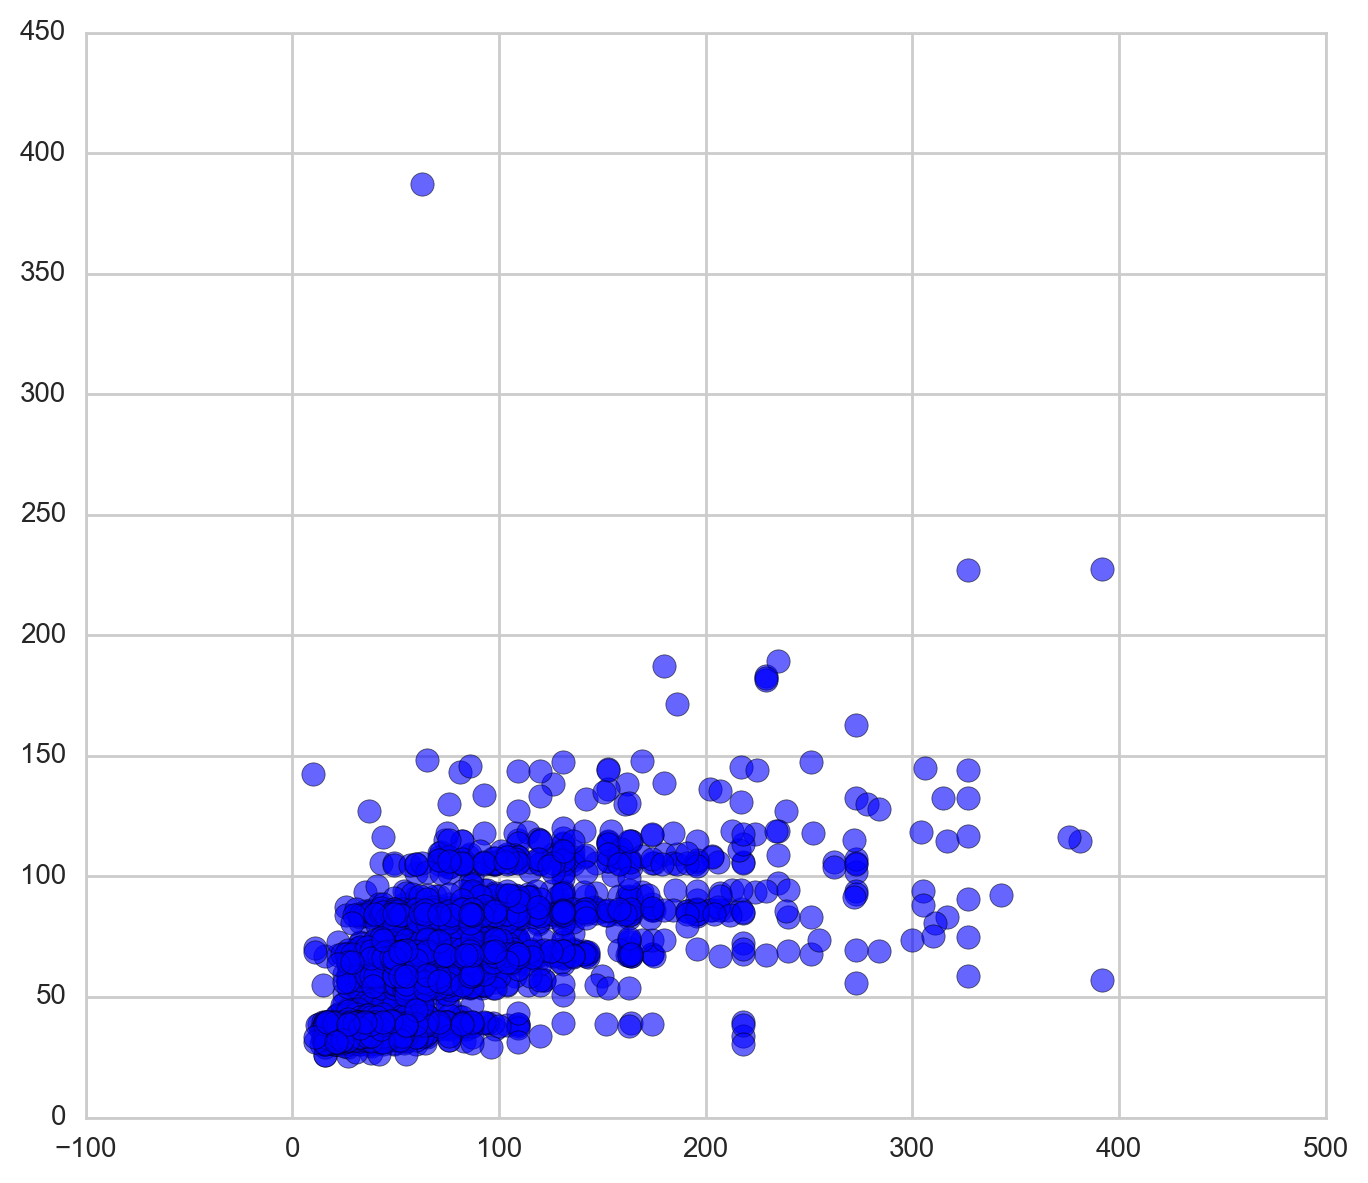

In [30]:
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(np.exp(y_test), np.exp(y_pred_lasso), s=70, alpha=0.6)
plt.show()

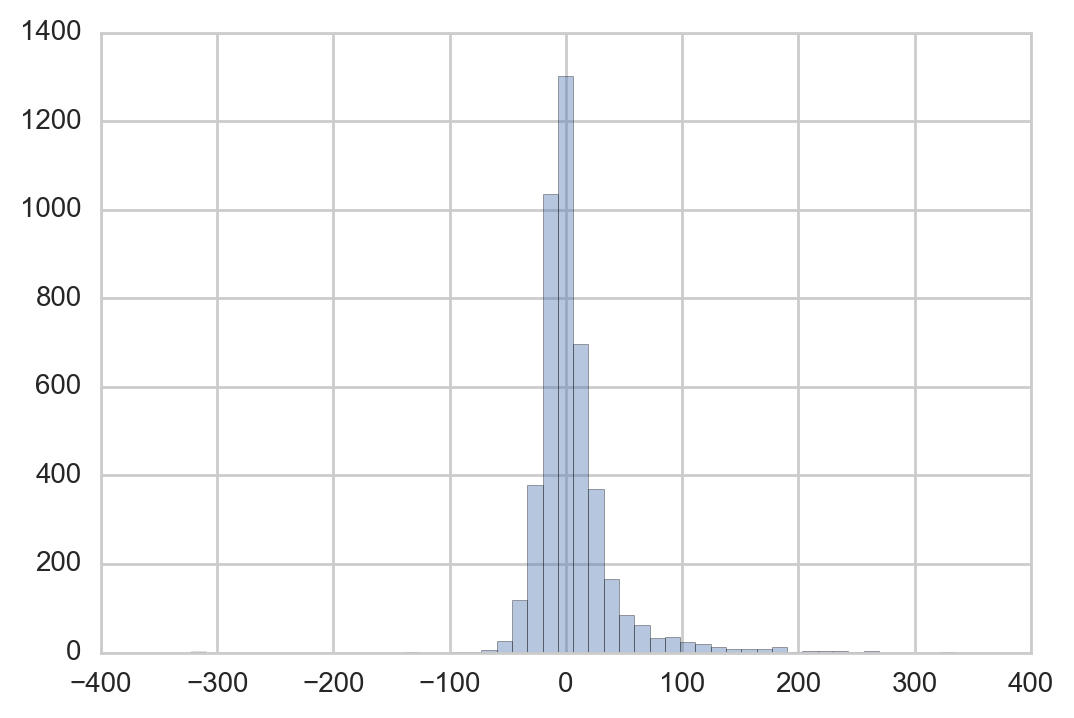

In [31]:
sns.distplot(residuals, bins=50, kde=False)

In [38]:
enet.fit(Xn_train, y_train)

enet_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':enet.coef_,
        'abscoef':np.abs(enet.coef_)
    })

enet_coef.sort_values('abscoef', ascending=False, inplace=True)
enet_coef[enet_coef.coef != 0].head(25)


,abscoef,coef,variable
12,0.263829,-0.263829,room_type[T.Private room]
15,0.150159,0.150159,bedrooms
13,0.085154,-0.085154,room_type[T.Shared room]
14,0.026789,0.026789,bathrooms
16,0.024904,-0.024904,dist_arprt
5,0.024605,-0.024605,neighborhood[Neukolln]
17,0.017353,0.017353,host_count
7,0.015074,-0.015074,neighborhood[Reinickendorf]
2,0.010890,-0.010890,neighborhood[Lichtenberg]
6,0.008650,0.008650,neighborhood[Pankow]


In [33]:
# plt.plot(enet.coef_, color='lightgreen', linewidth=2,
#          label='Elastic net coefficients')
# plt.plot(lassocv.coef_, color='gold', linewidth=2,
#          label='Lasso coefficients')
# #plt.plot(linmod.coef_, '--', color='navy', label='original coefficients')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
# plt.show()

In [40]:
enet_coef = enet_coef.reset_index(drop=True)


In [37]:
# linmod.fit(Xn_train, y_train)

# linmod_coef = pd.DataFrame({
#         'variable':X_train.columns,
#         'coef':linmod.coef_,
#         'abscoef':np.abs(linmod.coef_)
#     })

# linmod_coef.sort_values('abscoef', ascending=False, inplace=True)
# linmod_coef[linmod_coef.coef != 0].head(25)
# linmod_coef = linmod_coef.reset_index(drop=True)

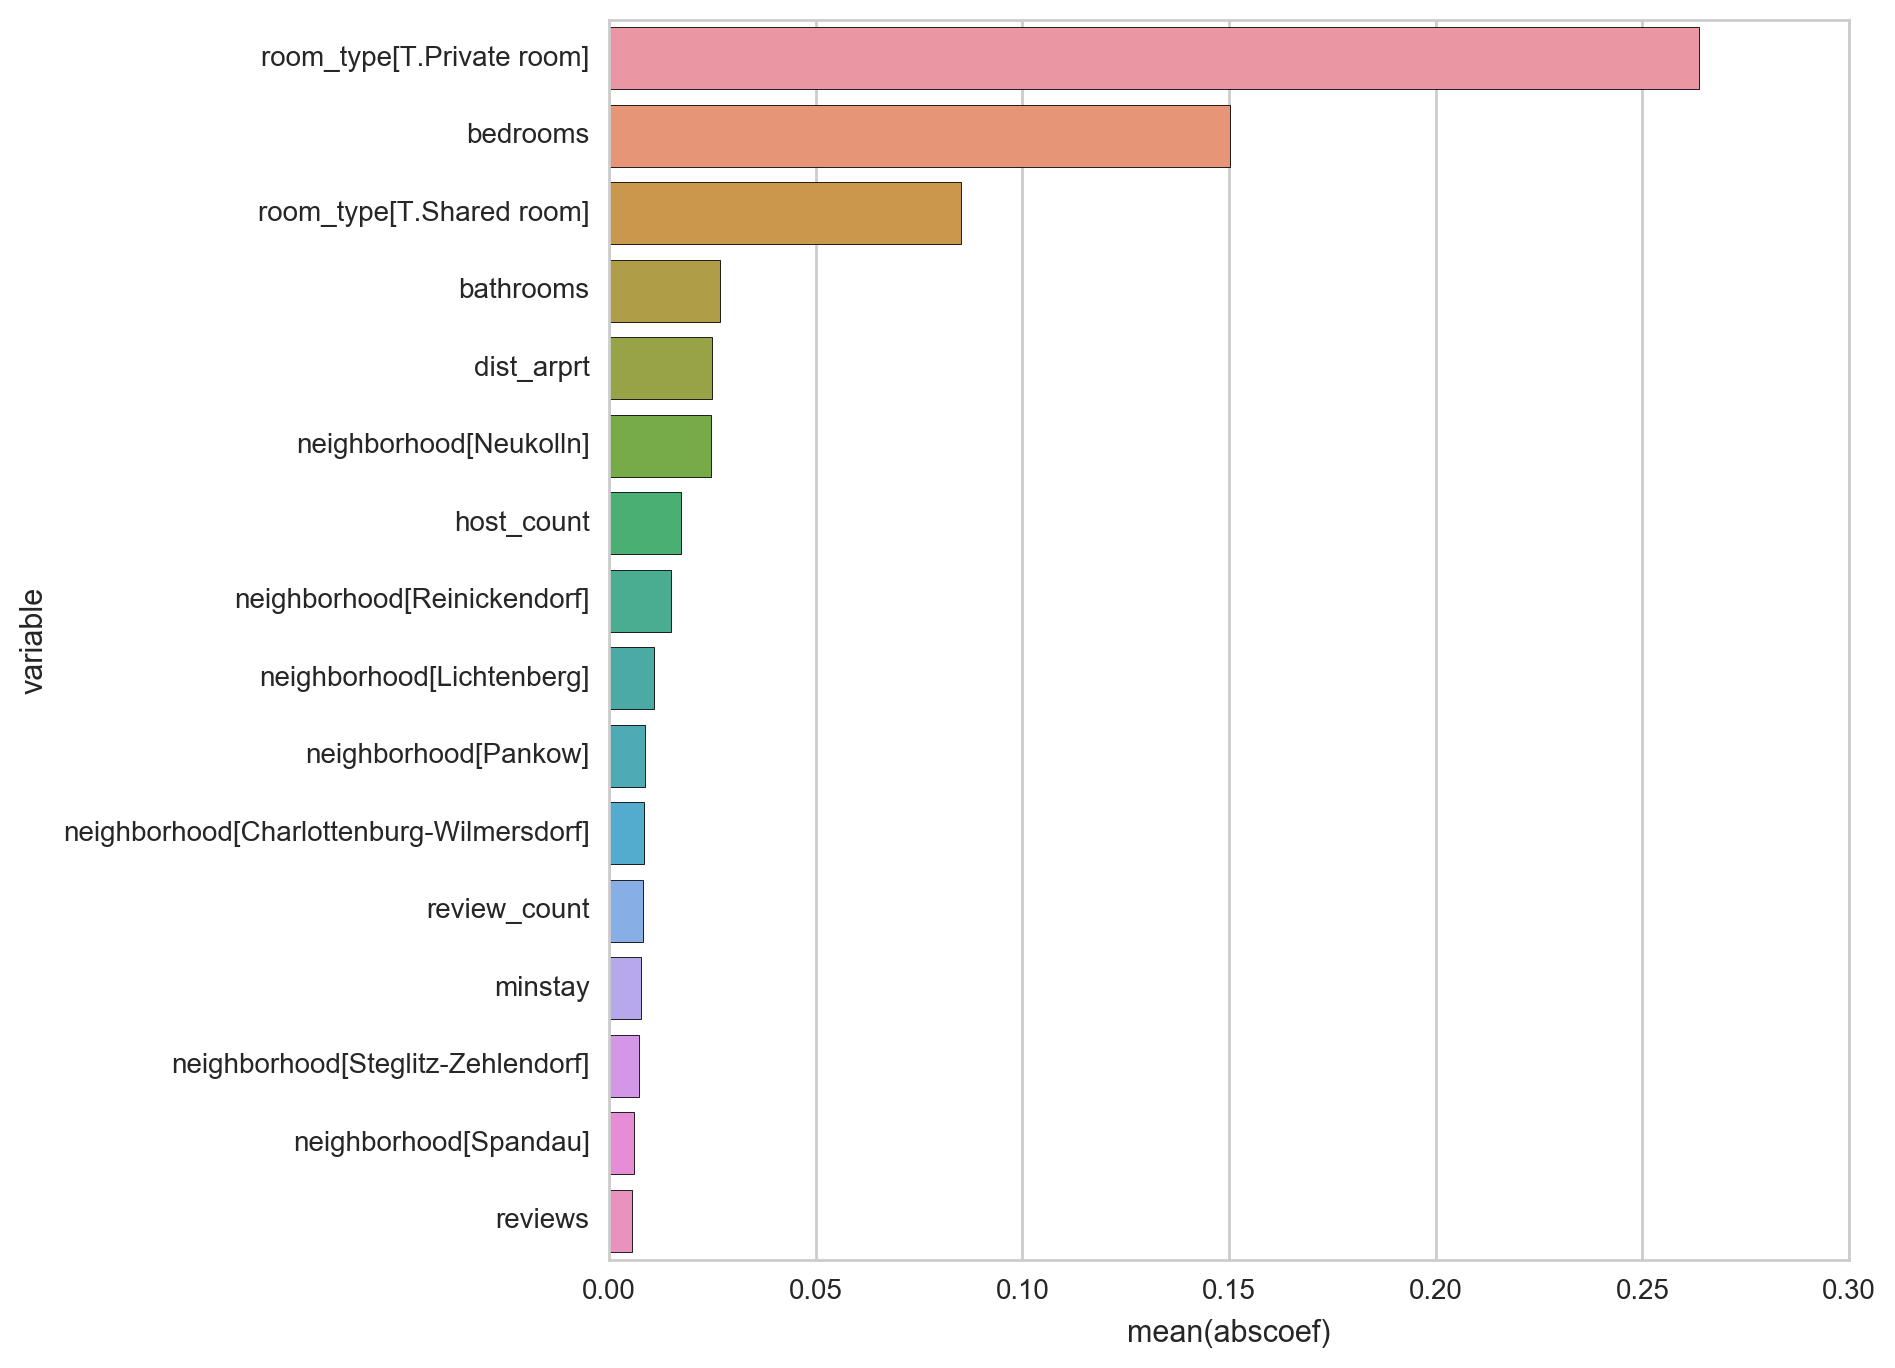

In [41]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = enet_coef.loc[0:15,:].variable, x = enet_coef.loc[0:15,:].abscoef, data=enet_coef.loc[0:15,:],
            ax=ax
           )



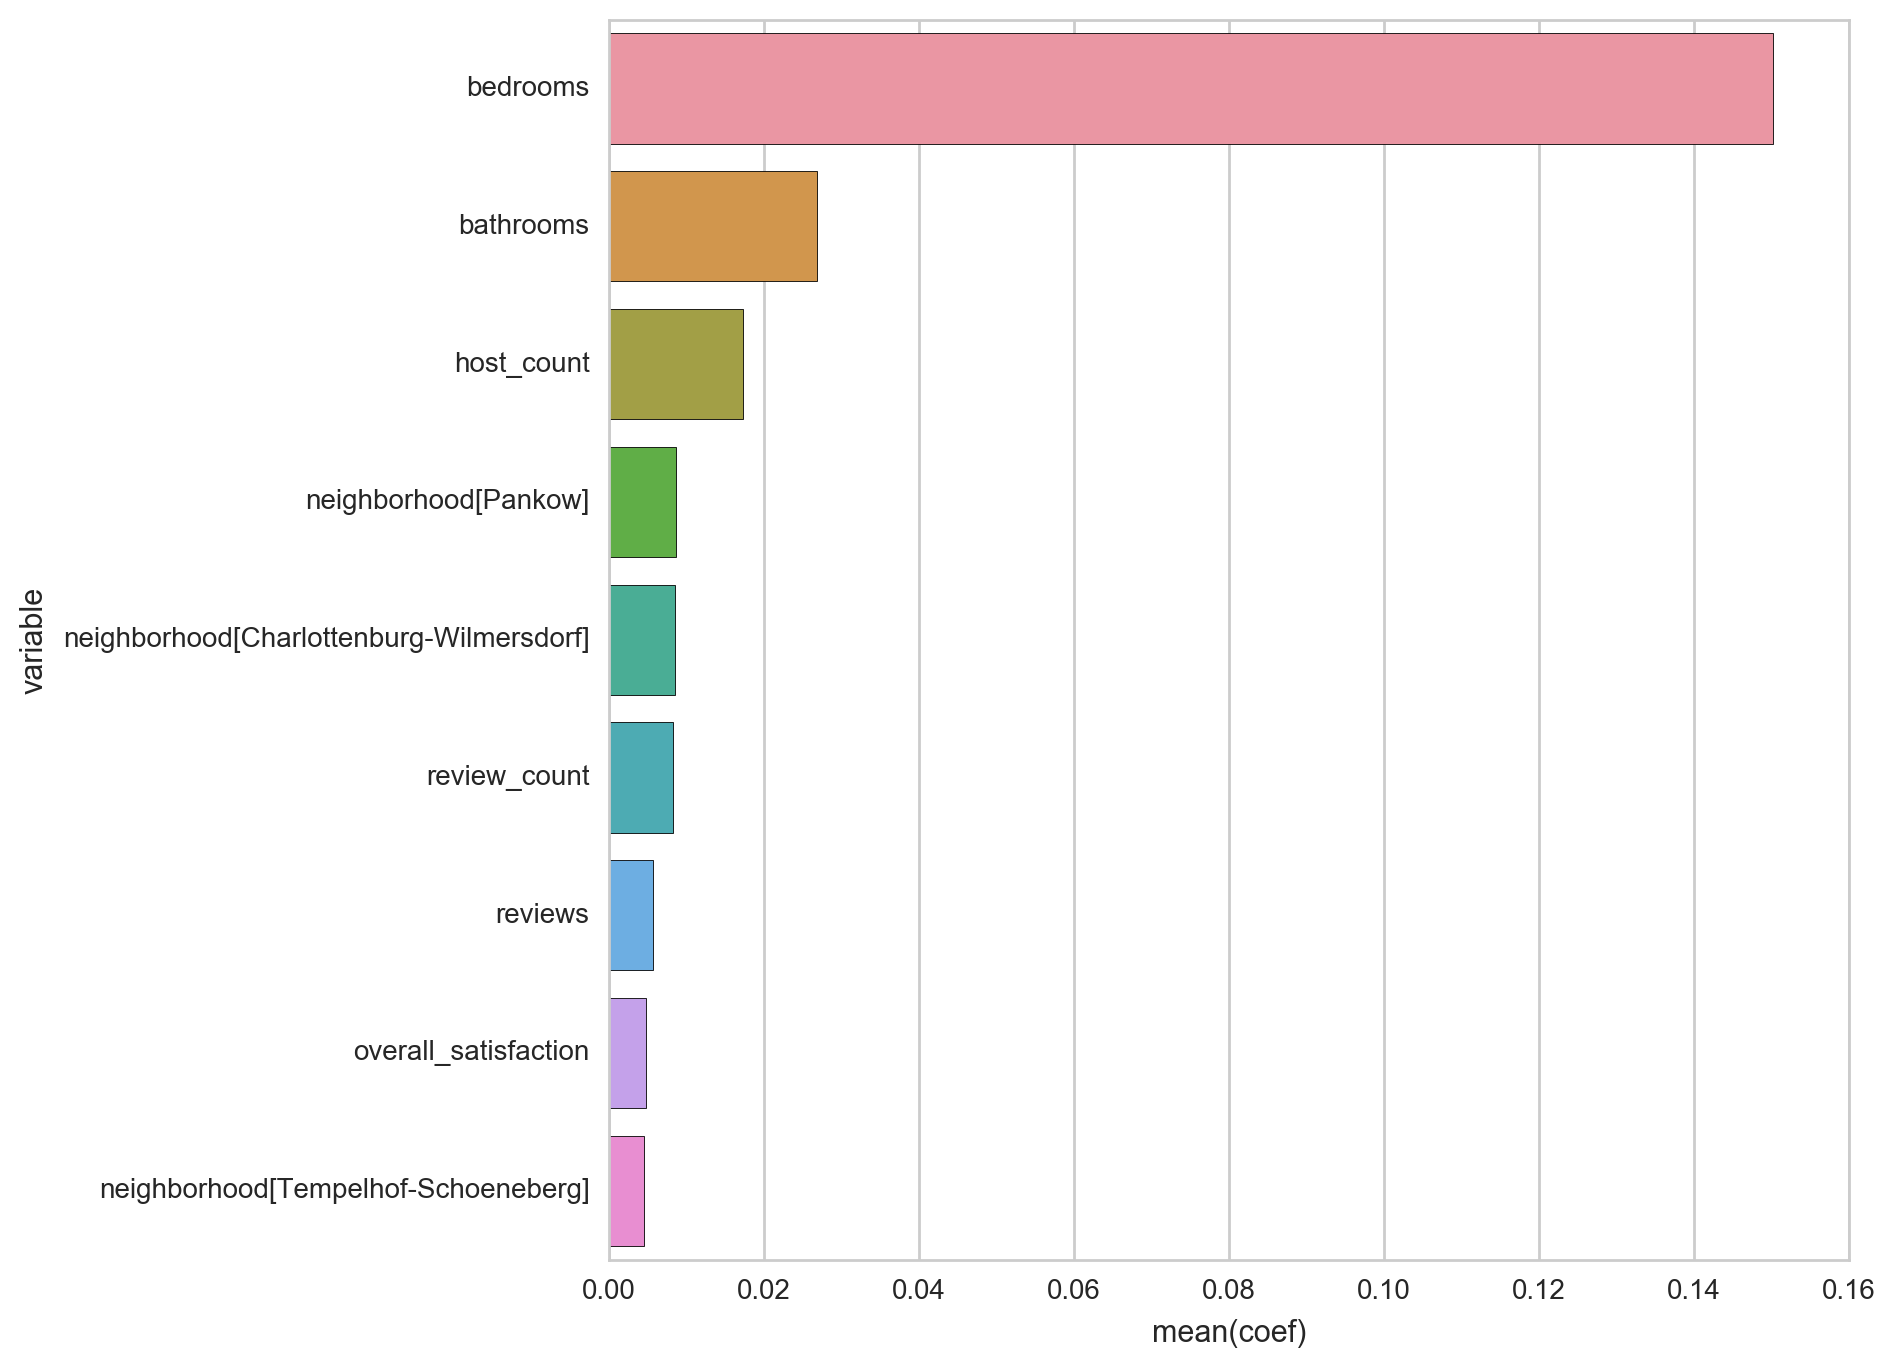

In [42]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = enet_coef[enet_coef.coef > 0].variable, x = enet_coef[enet_coef.coef > 0].coef, data=enet_coef,
            ax=ax
           )
plt.show()

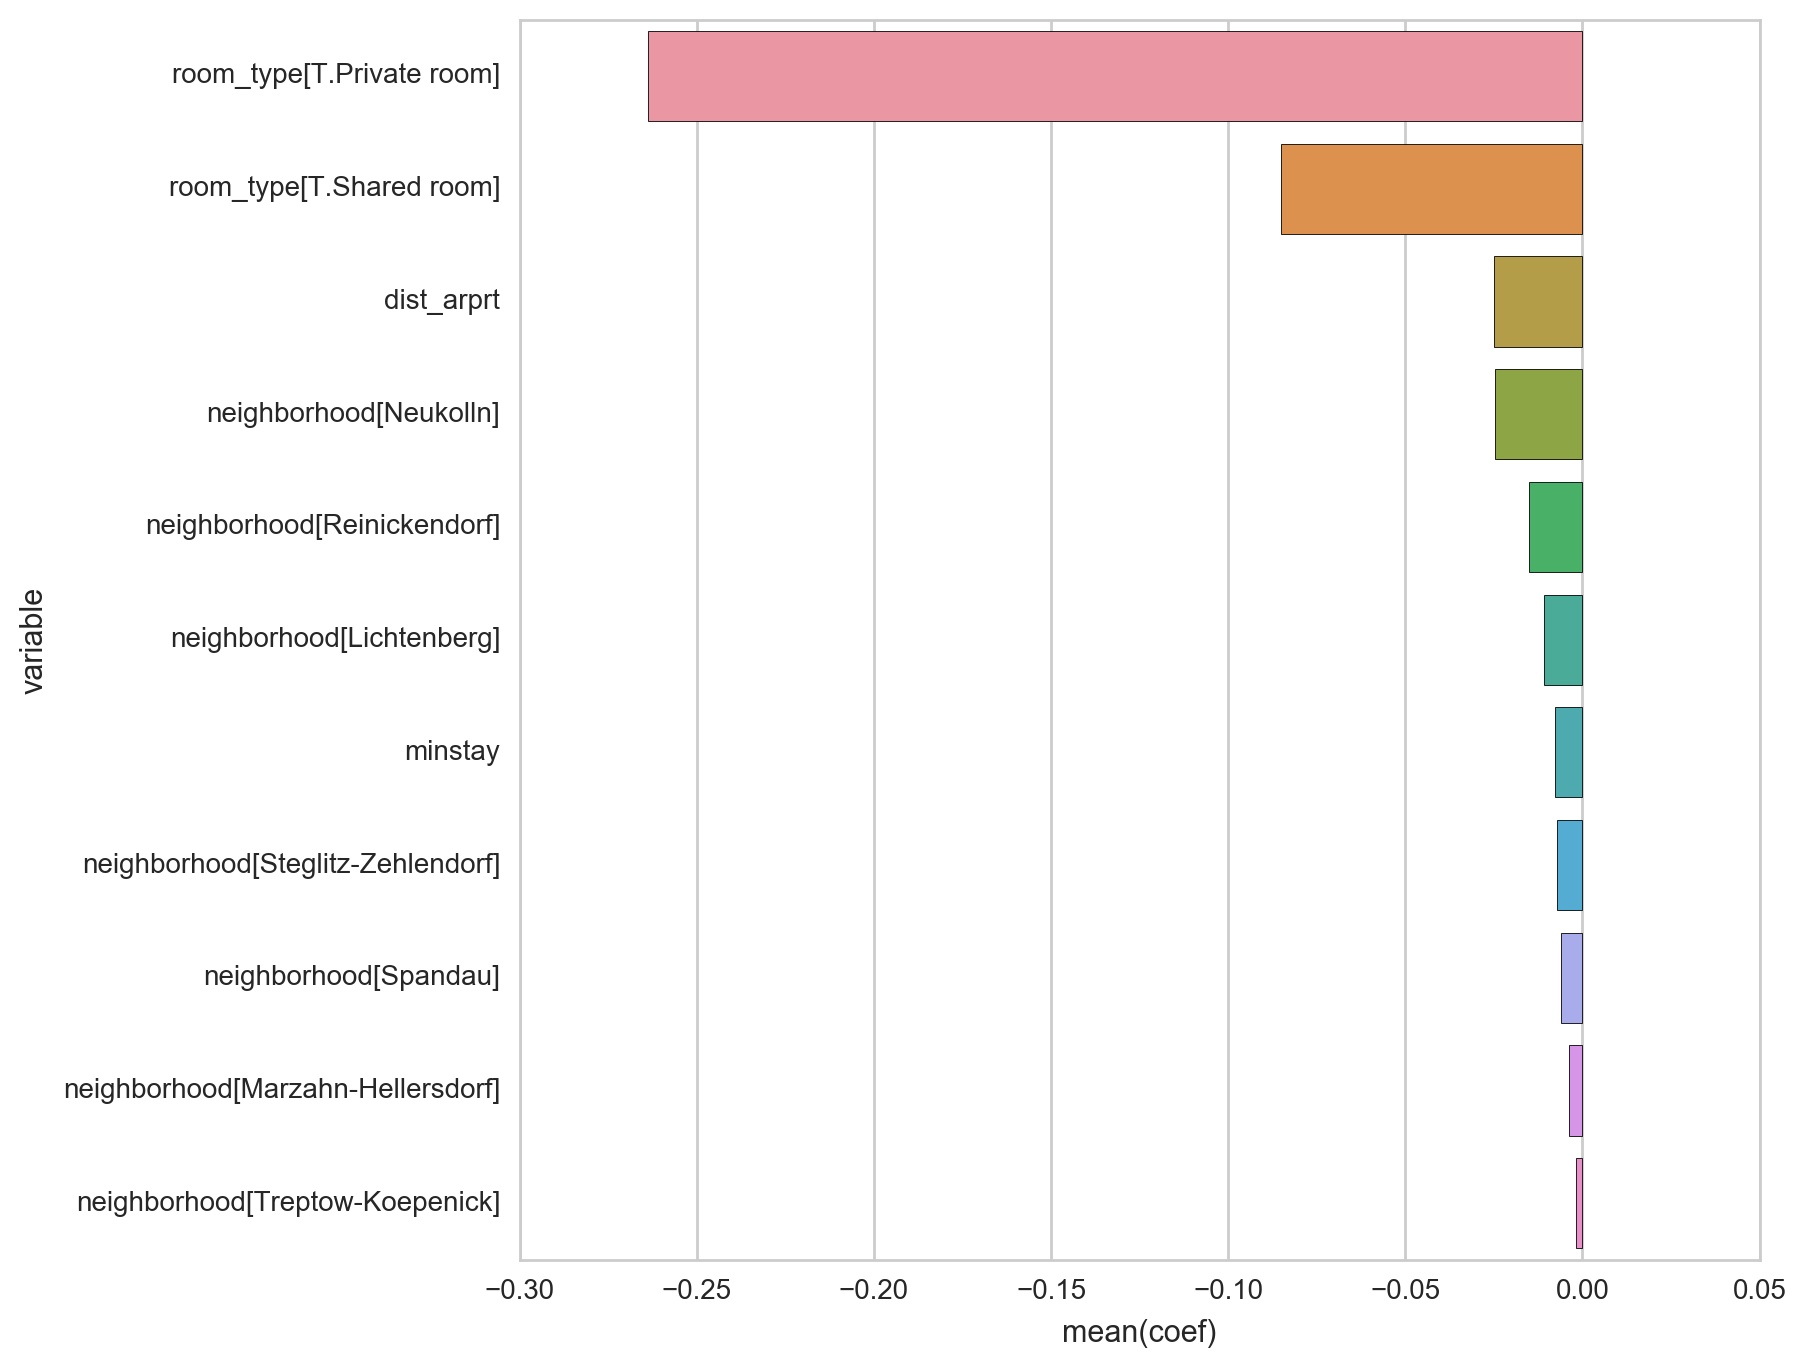

In [43]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = enet_coef[enet_coef.coef < 0].variable, x = enet_coef[enet_coef.coef < 0].coef, data=enet_coef,
            ax=ax
           )
plt.show()